# Initialize Notebook

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as pe
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import uproot
import os
import tqdm
import pandas as pd
import pickle as pkl
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from scipy.spatial.distance import cdist
import torch
import torch.nn as nn
import cv2 as cv
from joblib import Parallel, delayed
import h5py

# %matplotlib qt
%matplotlib inline

In [2]:
sys.path.append('../python/')

from filterMethods import *
from timeMethods import *
from gridMethods import *
from trackReconstructionMethods import *
from vertexReconstructionMethods import *
from hitAccuracyMethods import *
from statisticsMethods import *
from importMethods import *
from constants import *
from plotMethods import *
from UNetMethods import *

import plotParameters

In [3]:
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

# Load Data

In [4]:
useHistograms = True # if True use histograms, if False use tupple data

checkFiles = False # check if run ROOT files (1) exit, (2) have enough hits, (3) have enough primary particle steps, (4) all DSPS hit histograms are the same size

dataDir = '/Users/noah-everett/Documents_non-iCloud/DSPS/'
tmpDir  = dataDir+'tmp/'

fileNumbers = [i for i in range(1138)] # the ML data set has 1138 files
runDataRoot_filePaths = ['/Users/noah-everett/Documents/FNAL/Geant4/USSD_Geant4/runs/MLtrainData/multievent_{}.root'.format(i) for i in fileNumbers]
runDataRoot_hits_histDir = '/photoSensor_hits_histograms'
runDataRoot_hits_treeName = 'photoSensor_hits;1'
runDataRoot_primary_treeName = 'primary;1'

saveDf_hits                = True
saveDf_primary             = True
saveDfOnlyIfNoFile_hits    = True
saveDfOnlyIfNoFile_primary = True
saveDf_hits_basePath       = tmpDir+'simDF/MLdata_DF_hits'    # directory and beginning of file name
saveDf_primary_basePath    = tmpDir+'simDF/MLdata_DF_primary' # directory and beginning of file name

saveGrid_hits_npy                = False
saveGrid_primary_npy             = False
saveGrids_h5                     = True
saveGridOnlyIfNoFile_hits_npy    = True
saveGridOnlyIfNoFile_primary_npy = True
saveGridOnlyIfNoFile_h5          = True
saveGrid_hits_basePath_npy       = tmpDir+'MLdata/MLdata_grid_hits'    # directory and beginning of file name
saveGrid_primary_basePath_npy    = tmpDir+'MLdata/MLdata_grid_primary' # directory and beginning of file name
saveGrids_h5                     = tmpDir+'MLdata/MLdata_grids'        # directory and beginning of file name

saveModel          = True
saveModel_basePath = 'data/MLmodels/MLmodel' # directory and beginning of file name

In [19]:
minHits = 0
minPrimarySteps = 30

if (saveDf_hits or saveDf_primary) and checkFiles:
    DSPSsizes = [get_histogram_sizes(fileName, runDataRoot_hits_histDir) for fileName in tqdm.tqdm(runDataRoot_filePaths)]
    assert len(np.unique(np.array(DSPSsizes).reshape(-1, 2))) >  0, 'No data found?'
    assert len(np.unique(np.array(DSPSsizes).reshape(-1, 2))) == 1, 'Different sizes: {}'.format(np.unique(DSPSsizes))

    nHits = [get_histogram_nHits_total(fileName, runDataRoot_hits_histDir) for fileName in tqdm.tqdm(runDataRoot_filePaths)]
    nSteps = [len(get_primary_pdg(fileName, runDataRoot_primary_treeName)) for fileName in tqdm.tqdm(runDataRoot_filePaths)]

    fileNumbers     = [fileNumber for fileNumber, nHit in zip(fileNumbers          , nHits) if nHit > minHits]
    runDataRootPath = [fileName   for fileName  , nHit in zip(runDataRoot_filePaths, nHits) if nHit > minHits]

    fileNumbers     = [fileNumber for fileNumber, nStep in zip(fileNumbers          , nSteps) if nStep > minPrimarySteps]
    runDataRootPath = [fileName   for fileName  , nStep in zip(runDataRoot_filePaths, nSteps) if nStep > minPrimarySteps]

print('len(runDataRootPaths):', len(runDataRoot_filePaths))

len(runDataRootPaths): 1138


In [5]:
dfPaths_hits    = [f"{saveDf_hits_basePath}_{i}.parquet"    for i in fileNumbers]
dfPaths_primary = [f"{saveDf_primary_basePath}_{i}.parquet" for i in fileNumbers]

In [21]:
def rToTheta(r):
    return r/(CM_PER_RAD*MM_PER_CM)

if saveDf_hits:
    for i, (fileName, dfPath_hits) in tqdm.tqdm(enumerate(zip(runDataRoot_filePaths, dfPaths_hits)), total=len(runDataRoot_filePaths)):
        if saveDfOnlyIfNoFile_hits and os.path.exists(dfPath_hits):
            continue
        df_hits = pd.DataFrame(columns=['sensor_name', 'sensor_direction', 'sensor_position', 'sensor_wall', 'relativePosition_binned', 'relativePosition_nBin'])
        if useHistograms:
            photosensor_IDs, photosensor_directions, photosensor_positions, photosensor_walls, position_relative_binned, position_relative_nBin = get_histogram_hits_tuple(fileName, runDataRoot_hits_histDir, True)
            df_hits['sensor_name'            ] = photosensor_IDs
            df_hits['sensor_direction'       ] = photosensor_directions
            df_hits['sensor_position'        ] = photosensor_positions
            df_hits['sensor_wall'            ] = photosensor_walls
            df_hits['relativePosition_binned'] = position_relative_binned
            df_hits['relativePosition_nBin'  ] = position_relative_nBin
        else:
            df_hits['sensor_name'            ] = get_photosensor_hits_photosensor_ID          (fileName, runDataRoot_hits_treeName, runDataRoot_hits_histDir, verbose=False)
            df_hits['sensor_direction'       ] = get_photosensor_hits_photosensor_direction   (fileName, runDataRoot_hits_treeName, runDataRoot_hits_histDir, verbose=False)
            df_hits['sensor_position'        ] = get_photosensor_hits_photosensor_position    (fileName, runDataRoot_hits_treeName, runDataRoot_hits_histDir, verbose=False)
            df_hits['sensor_wall'            ] = get_photosensor_hits_photosensor_wall        (fileName, runDataRoot_hits_treeName, runDataRoot_hits_histDir, verbose=False)
            # df_hits['relativePosition'       ] = get_photosensor_hits_position_relative       (fileName, runDataRoot_hits_treeName, runDataRoot_hits_histDir, verbose=False)
            df_hits['relativePosition_binned'] = get_photosensor_hits_position_relative_binned(fileName, runDataRoot_hits_treeName, runDataRoot_hits_histDir, verbose=False)
            df_hits['relativePosition_nBin'  ] = get_photosensor_hits_position_relative_nBin  (fileName, runDataRoot_hits_treeName, runDataRoot_hits_histDir, verbose=False)
            df_hits['initialPosition'        ] = get_photosensor_hits_position_initial        (fileName, runDataRoot_hits_treeName,          verbose=False)

        df_hits = make_r                            (df_hits)
        df_hits = filter_r                          (df_hits, Y_LIM)
        df_hits = make_theta                        (df_hits, rToTheta)
        df_hits = make_phi                          (df_hits)
        df_hits = make_reconstructedVector_direction(df_hits)
        if 'initialPosition' in df_hits.columns:
            df_hits = make_relativeVector(df_hits)
    
        df_hits.to_parquet(dfPath_hits, compression='snappy')

100%|██████████| 1138/1138 [00:00<00:00, 74273.59it/s]


In [22]:
def processPrimaryFile(fileName, treeName, dfPath_primary):
    if saveDfOnlyIfNoFile_primary and os.path.exists(dfPath_primary):
        return

    df_primary = pd.DataFrame(columns=['position', 'pdg'])
    df_primary['position' ] = get_primary_position(fileName, treeName)
    df_primary['pdg'      ] = get_primary_pdg     (fileName, treeName)
    df_primary = df_primary[df_primary['pdg'] == 13] # muon
    df_primary = df_primary[df_primary['position'].apply(lambda x:
        x[0] > -DETECTOR_SIZE_MM[0]/2 and x[0] < DETECTOR_SIZE_MM[0]/2 and
        x[1] > -DETECTOR_SIZE_MM[1]/2 and x[1] < DETECTOR_SIZE_MM[1]/2 and
        x[2] > -DETECTOR_SIZE_MM[2]/2 and x[2] < DETECTOR_SIZE_MM[2]/2
    )]

    df_primary.to_parquet(dfPath_primary, compression='snappy')

args_list = [(fileName, runDataRoot_primary_treeName, dfPath_primary) for fileName, dfPath_primary in zip(runDataRoot_filePaths, dfPaths_primary)]

if saveDf_primary:
    Parallel(n_jobs=4)(delayed(processPrimaryFile)(*args) for args in tqdm.tqdm(args_list))

100%|██████████| 1138/1138 [00:01<00:00, 751.78it/s]


# Make or Load Grid

In [7]:
N = 80
gridSize_input  = (N, N, N)
gridSize_output = (N, N, N)

voxelGrid_make_errors               = False
voxelGrid_make_walls                = True
voxelGrid_make_walls_combine        = False
voxelGrid_make_walls_combine_method = expNWalls
voxelGrid_make_vectors_combine      = True

In [8]:
gridPaths_hits_npy    = [f"{saveGrid_hits_basePath_npy}_{i}_{gridSize_input[0]}x{gridSize_input[1]}x{gridSize_input[2]}_{'withWalls' if voxelGrid_make_walls else 'noWalls'}_{'withErrors' if voxelGrid_make_errors else 'noErrors'}.npy" for i in fileNumbers]
gridPaths_primary_npy = [f"{saveGrid_primary_basePath_npy}_{i}_{gridSize_output[0]}x{gridSize_output[1]}x{gridSize_output[2]}.npy"                                                                                                        for i in fileNumbers]
gridPaths_h5          = [f"{saveGrids_h5}_{i}_{gridSize_output[0]}x{gridSize_output[1]}x{gridSize_output[2]}_{'withWalls' if voxelGrid_make_walls else 'noWalls'}_{'withErrors' if voxelGrid_make_errors else 'noErrors'}.h5"             for i in fileNumbers]

print('gridPaths_hits_npy[0]:', gridPaths_hits_npy[0])
print('gridPaths_primary_npy[0]:', gridPaths_primary_npy[0])
print('gridPaths_h5[0]:', gridPaths_h5[0])

gridPaths_hits_npy[0]: /Users/noah-everett/Documents_non-iCloud/DSPS/tmp/MLdata/MLdata_grid_hits_0_80x80x80_withWalls_noErrors.npy
gridPaths_primary_npy[0]: /Users/noah-everett/Documents_non-iCloud/DSPS/tmp/MLdata/MLdata_grid_primary_0_80x80x80.npy
gridPaths_h5[0]: /Users/noah-everett/Documents_non-iCloud/DSPS/tmp/MLdata/MLdata_grids_0_80x80x80_withWalls_noErrors.h5


# Data

In [7]:
def doGridCreationAndSave(dfPath_hits, dfPath_primary, gridPath_hits_npy, gridPath_primary_npy, gridPath_h5):
    save_hits_npy    = True
    save_primary_npy = True
    save_h5          = True

    if saveGridOnlyIfNoFile_hits_npy and (not saveGrid_hits_npy or os.path.exists(gridPath_hits_npy)):
        save_hits_npy = False
    if saveGridOnlyIfNoFile_primary_npy and (not saveGrid_primary_npy or os.path.exists(gridPath_primary_npy)):
        save_primary_npy = False
    if saveGridOnlyIfNoFile_h5 and (not saveGrids_h5 or os.path.exists(gridPath_h5)):
        save_h5 = False

    if not save_hits_npy and not save_primary_npy and not save_h5:
        return
    
    x = None
    y = None

    if save_hits_npy or save_h5:
        try:
            df_hits    = pd.read_parquet(dfPath_hits)
        except Exception as e:
            raise e

        try:
            x = get_voxelGrid(
                grid_shape           = np.array(gridSize_input).astype(int),
                grid_dimensions      = np.array(DETECTOR_SIZE_MM),
                vector_starts        = np.array(df_hits['sensor_position'].to_list()).reshape(-1, 3),
                vector_directions    =-np.array(df_hits['reconstructedVector_direction'].to_list()).reshape(-1, 3),
                vector_weights       = None,
                vector_start_walls   = wallStringToInt(df_hits['sensor_wall'].to_numpy().astype(str)),
                walls                = voxelGrid_make_walls,
                walls_combine        = voxelGrid_make_walls_combine,
                walls_combine_method = voxelGrid_make_walls_combine_method,
                vector_combine       = voxelGrid_make_vectors_combine,
            )
        except Exception as e:
            print('Error in processHitsFile:', e)
        
        assert x.max() <= len(df_hits), f"Error: x.max() = {x.max()} > len(df_hits) = {len(df_hits)}"
        assert x.max() <= len(df_hits)-1, f"Error: x.max() = {x.max()} > len(df_hits)-1 = {len(df_hits)-1}"

    if save_primary_npy or save_h5:
        try:
            df_primary = pd.read_parquet(dfPath_primary)
        except Exception as e:
            raise e

        try:
            y = make_voxelGrid_truth(
                np.array(df_primary['position'].to_list()),
                shape=gridSize_output,
                detectorDimensions=DETECTOR_SIZE_MM,
                makeErrors=False
            )[0]
        except Exception as e:
            print('Error in processPrimaryFile:', e)

        assert y.max() <= len(df_primary), f"Error: y.max() = {y.max()} > len(df_primary) = {len(df_primary)}"
        assert y.max() <= len(df_primary)-1, f"Error: y.max() = {y.max()} > len(df_primary)-1 = {len(df_primary)-1}"

    if save_h5:
        with h5py.File(gridPath_h5, 'w') as f:
            f.create_dataset('x', data=np.moveaxis(x, -1, 0))
            f.create_dataset('y', data=y)
    if save_hits_npy:
        np.save(gridPath_hits_npy, x)
    if save_primary_npy:
        np.save(gridPath_primary_npy, y)

args_list = [
    (dfPaths_hits[i], dfPaths_primary[i], gridPaths_hits_npy[i], gridPaths_primary_npy[i], gridPaths_h5[i])
    for i in range(len(dfPaths_hits))
]

if saveGrid_hits_npy or saveGrid_primary_npy or saveGrids_h5:
    results = Parallel(n_jobs=-1)(
        delayed(doGridCreationAndSave)(*args) for args in tqdm.tqdm(args_list)
    )

NameError: name 'gridPaths_hits_npy' is not defined

In [9]:
nTest = 20
nVal  = 10

np.random.seed(42)

testIndices = np.random.choice(len(dfPaths_hits), nTest, replace=False)
valIndices  = np.random.choice(np.delete(np.arange(len(dfPaths_hits)), testIndices), nVal, replace=False)

X_train_indices = np.delete(np.arange(len(dfPaths_hits)), np.concatenate((testIndices, valIndices)))
Y_train_indices = np.delete(np.arange(len(dfPaths_hits)), np.concatenate((testIndices, valIndices)))
X_test_indices  = np.array(testIndices)
Y_test_indices  = np.array(testIndices)
X_val_indices   = np.array(valIndices)
Y_val_indices   = np.array(valIndices)

paths_train = [gridPaths_h5[i] for i in X_train_indices]
paths_test  = [gridPaths_h5[i] for i in X_test_indices]
paths_val   = [gridPaths_h5[i] for i in X_val_indices]

# print('X_train_indices:', X_train_indices.tolist())
# print('X_test_indices:' , X_test_indices .tolist())
# print('X_val_indices:'  , X_val_indices  .tolist())

print('len(paths_train):', len(paths_train))
print('len(paths_test):' , len(paths_test))
print('len(paths_val):'  , len(paths_val))

assert len(paths_train) == len(X_train_indices)
assert len(paths_test ) == len(X_test_indices )
assert len(paths_val  ) == len(X_val_indices  )

assert len(np.intersect1d(X_train_indices, X_test_indices)) == 0, f"Overlap: {np.intersect1d(X_train_indices, X_test_indices)}"
assert len(np.intersect1d(X_train_indices, X_val_indices )) == 0, f"Overlap: {np.intersect1d(X_train_indices, X_val_indices )}"
assert len(np.intersect1d(X_test_indices , X_val_indices )) == 0, f"Overlap: {np.intersect1d(X_test_indices , X_val_indices )}"

len(paths_train): 1108
len(paths_test): 20
len(paths_val): 10


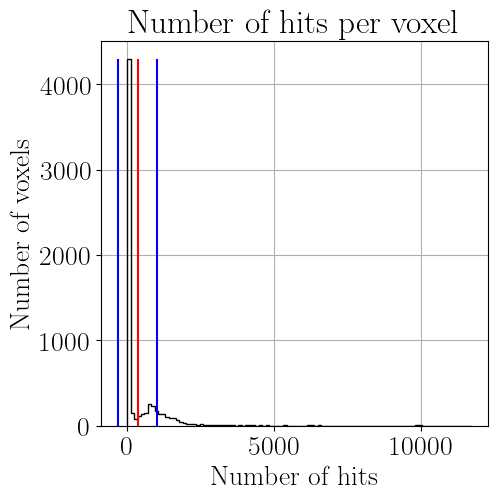

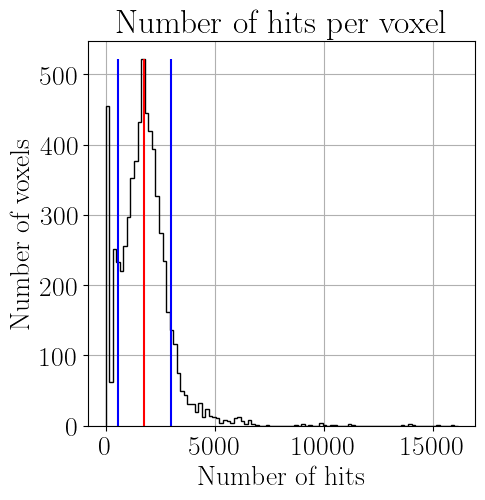

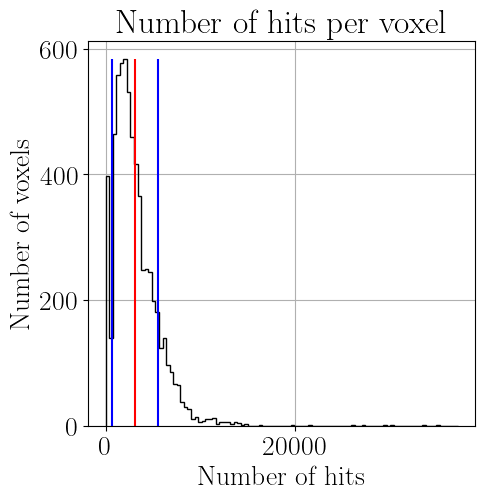

In [14]:
indicies = [] #[1, 2, 3]

for ind in indicies:
    with h5py.File(gridPaths_h5[ind], 'r') as f:
        x = f['x'][:]

    nHits = x[ind].sum(axis=-1)
    nHits = nHits.flatten()

    fig, ax = plt.subplots(1, 1, figsize=(5,5))

    n, _, _ = ax.hist(nHits, bins=np.arange(nHits.min(), nHits.max(), (nHits.max()-nHits.min())/100), histtype='step', color='black')
    ax.vlines(np.mean(nHits), 0, np.max(n), color='red')
    ax.vlines(np.mean(nHits)+np.std(nHits), 0, np.max(n), color='blue')
    ax.vlines(np.mean(nHits)-np.std(nHits), 0, np.max(n), color='blue')

    # ax.set_yscale('log')
    ax.grid(True)

    ax.set_xlabel('Number of hits')
    ax.set_ylabel('Number of voxels')
    ax.set_title('Number of hits per voxel')

    plt.show()

In [15]:
# %matplotlib qt
%matplotlib inline

indices = [1,2,3]#[46, 51, 52]
# indices = X_train_indices

plots = [False, False, True]
# plots = [True, True, True]
format = 'pdf'
resolution = 300

xEdges = np.linspace(-DETECTOR_SIZE_MM[0]/2, DETECTOR_SIZE_MM[0]/2, gridSize_input[0] + 1)
yEdges = np.linspace(-DETECTOR_SIZE_MM[1]/2, DETECTOR_SIZE_MM[1]/2, gridSize_input[1] + 1)
zEdges = np.linspace(-DETECTOR_SIZE_MM[2]/2, DETECTOR_SIZE_MM[2]/2, gridSize_input[2] + 1)

yEdges, xEdges, zEdges = np.meshgrid(xEdges, yEdges, zEdges)

alpha_empty  = 0.10
alpha_filled = 0.45
alpha_true   = 0.70

##################################################################################################
##################################################################################################
##################################################################################################

for ind in tqdm.tqdm(indices):
    continue

    x = np.load(gridPaths_hits_npy[ind])
    y = np.load(gridPaths_primary_npy[ind])

    vals = x.sum(axis=-1)

    # set minHits to the 1 sigma value
    valsMinusOuterLayor = vals[1:-1, 1:-1, 1:-1]
    minHits = valsMinusOuterLayor.mean()
    maxHits = valsMinusOuterLayor.max()

    # globalColorNorm = cm.colors.Normalize(vmin=0, vmax=np.max([X_train[ind].sum(axis=-1).max()]))
    globalColorNorm = cm.colors.Normalize(vmin=minHits, vmax=maxHits)
    # globalColorNorm = cm.colors.LogNorm(vmin=1, vmax=25)

    vals = np.where(vals < minHits, 0, vals)
    colors = cm.viridis(globalColorNorm(vals))

##################################################################################################
##################################################################################################
##################################################################################################

    if plots[0]:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')

        ax = plot_grid(
            ax,
            xEdges,
            yEdges,
            zEdges,
            recoGrid=vals,
            recoGridFaceColors=colors,
            recoGridEdgeColors=np.clip(colors*2-0.5, 0, 1),
            recoGridAlpha=alpha_filled,
            linewidth=0.5,
            cbar=True,
            colorNorm=globalColorNorm,
            cmap=cm.viridis
        )

        plt.savefig('../figures/voxelGrid_{}.{}'.format(ind, format), bbox_inches='tight', transparent=True, dpi=resolution)
        plt.show()

    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    if plots[1]:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')

        primary = pd.read_parquet(dfPaths_primary[X_train_indices[ind]])['position'].to_list()
        primary = np.array(primary)

        ax = plot_grid(
            ax,
            xEdges,
            yEdges,
            zEdges,
            trueGrid=y,
            truePoints=primary,
            trueGridFaceColors='r',
            trueGridEdgeColors='k',
            trueGridAlpha=alpha_true,
            linewidth=0.5,
            truePointsColor='b', 
            truePointsSize=10, 
            truePointsAlpha=1, 
            truePointsMarker='o'
        )

        plt.savefig('../figures/voxelGrid_truth_{}.{}'.format(ind, format), bbox_inches='tight', transparent=True, dpi=resolution)
        plt.show()

    ##################################################################################################
    ##################################################################################################
    ##################################################################################################
    ##################################################################################################

    if plots[2]:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')
        
        ax = plot_grid(
            ax,
            xEdges,
            yEdges,
            zEdges,
            recoGrid=vals,
            recoGridFaceColors=colors,
            recoGridEdgeColors=np.clip(colors*2-0.5, 0, 1),
            recoGridAlpha=alpha_filled,
            trueGrid=y,
            trueGridFaceColors='r',
            trueGridEdgeColors='k',
            trueGridAlpha=alpha_true,
            linewidth=0.5,
            cbar=True,
            colorNorm=globalColorNorm,
            cmap=cm.viridis,
            ignoreOuterNVoxels=0
        )

        ax.set_axis_off()
        ax.set_aspect('equal')
        plt.savefig('../figures/voxelGrid_both_{}.{}'.format(ind, format), bbox_inches='tight', transparent=True, dpi=resolution)
        plt.show()

100%|██████████| 3/3 [00:00<00:00, 111353.20it/s]


In [16]:
if not os.path.exists('../tmp'):
    os.makedirs('../tmp')
if not os.path.exists('../tmp/train'):
    os.makedirs('../tmp/train')
    os.system('rm -r ../tmp/train/*')
if not os.path.exists('../tmp/test'):
    os.makedirs('../tmp/test')
os.system('rm -r ../tmp/test/*')
if not os.path.exists('../tmp/val'):
    os.makedirs('../tmp/val')
os.system('rm -r ../tmp/val/*')

for i, path in tqdm.tqdm(enumerate(paths_train)):
    os.system(f'cp {path} ../tmp/train/{i}.h5')
for i, path in tqdm.tqdm(enumerate(paths_test)):
    os.system(f'cp {path} ../tmp/test/{i+len(paths_train)}.h5')
for i, path in tqdm.tqdm(enumerate(paths_val)):
    os.system(f'cp {path} ../tmp/val/{i+len(paths_train)+len(paths_test)}.h5')

rm: ../tmp/test/*: No such file or directory
rm: ../tmp/val/*: No such file or directory
1108it [4:40:15, 15.18s/it] 
20it [02:06,  6.34s/it]
10it [00:00, 62.29it/s]


In [12]:
sys.path.append('../pytorch-3dunet/')
from pytorch3dunet.train import main

config = get_config(paths_train, paths_val, num_workers=40)
# config = get_config(tmpDir+'/train/', tmpDir+'/val/', num_workers=40)
save_config(config, tmpDir+'/config.yml')

main(['--config', tmpDir+'/config.yml'])

2024-11-04 17:14:20,676 [MainThread] WARNING ConfigLoader - CUDA not available, using CPU
2024-11-04 17:14:20,676 [MainThread] INFO ConfigLoader - Using MPS
2024-11-04 17:14:20,677 [MainThread] INFO TrainingSetup - {'eval_metric': {'name': 'BoundaryAdaptedRandError', 'threshold': 0.4, 'use_first_input': True, 'use_last_target': True}, 'loaders': {'label_internal_path': '/y', 'num_workers': 40, 'raw_internal_path': '/x', 'train': {'file_paths': ['/Users/noah-everett/Documents_non-iCloud/DSPS/tmp/MLdata/MLdata_grids_0_80x80x80_withWalls_noErrors.h5', '/Users/noah-everett/Documents_non-iCloud/DSPS/tmp/MLdata/MLdata_grids_1_80x80x80_withWalls_noErrors.h5', '/Users/noah-everett/Documents_non-iCloud/DSPS/tmp/MLdata/MLdata_grids_2_80x80x80_withWalls_noErrors.h5', '/Users/noah-everett/Documents_non-iCloud/DSPS/tmp/MLdata/MLdata_grids_3_80x80x80_withWalls_noErrors.h5', '/Users/noah-everett/Documents_non-iCloud/DSPS/tmp/MLdata/MLdata_grids_4_80x80x80_withWalls_noErrors.h5', '/Users/noah-everett/

KeyboardInterrupt: 

In [17]:
from pytorch3dunet.unet3d.model import UNet3D
from pytorch3dunet.unet3d.utils import get_tensorboard_formatter, create_optimizer, \
    create_lr_scheduler, get_number_of_learnable_parameters
from pytorch3dunet.unet3d.losses import get_loss_criterion

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print ("MPS device found.")
elif torch.cuda.is_available():
    x = torch.ones(1, device=torch.device("cuda"))
    print ("CUDA device found.")
else:
    x = torch.ones(1, device=torch.device("cpu"))
    print ("No GPU found. Using CPU.")

loss_criterion = get_loss_criterion({'loss':{
    'name':'PixelWiseCrossEntropyLoss',
}})

model = UNet3D(in_channels=1, out_channels=1)
print('Number of parameters:', get_number_of_learnable_parameters(model))

MPS device found.
Number of parameters: 16318691
